# FIT5202 Data processing for big data

##  Activity: Machine Learning with Spark (Classification Using Decision Tree, Random Forest,  and Logistic Regression)

Last week we learnt about basics of machine learning with Apache Spark. **``MLlib``** is Apache Spark's scalable machine learning library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

We looked into transformers, estimators and machine learning pipeline in the last weeks tutorial activity.

This week we have learnt about different classification algorithms in the lecture. We will look into how to use the different popular family of classification and regression methods; Decision Trees and Random forests.

## Table of Contents

* [Bank case study: Will the client subscribe?](#one)
* [Data Loading and Preparation](#data-preparation)
* [Feature Engineering](#feature-engineering)
    * [StringIndexer](#feature-engineering)
    * [OneHotEncoder](#feature-engineering)
    * [VectorAssembler](#feature-engineering)
* [Pipeline API](#pipeline)
* [Train/Test Split](#train-test)
* [ML Classification Models](#models)
    * [Decision Tree](#dt)
    * [Random Forest](#rf)        
    * [Logistic Regression](#lr)    
* [Model Evaluation](#model-evaluation)
    * [Confusion Matrix](#confusion-matrix)
    * [Area Under the Curve](#roc)    
    * [Visualizing ROC Curve](#roc-viz)
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)
    * [Lab Task 4](#lab-task-4)
    * [Lab Task 5](#lab-task-5)
* [Challenge Tasks](#challenge-task)
    * [Challenge Task 1](#challenge-task)
    

## Bank case study: Will the client subscribe? <a class="anchor" id="one"></a>
<hr/>

The data was used to direct marketing campaigns of a banking institution. The marketing campaigns were based on phone calls. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit.

### **Attributes**

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'primary', 'secondary', 'tertiary', 'unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance : bank balance
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:
9. contact: contact communication type (categorical: 'cellular','telephone','unknown')
10. day: last contact day of the week (numerical: 1,2,...28,29,30)
1. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success','unknown')

### Output variable (desired target):
16. deposit - has the client subscribed a term deposit? (binary: 'yes','no')

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong> 

Complete the following steps for the initial part to get the data ready for the Classification Algorithms.

 1. **Loading data:** Load the <code>bank.csv</code> file using spark session
 2. **Prepare the data :** Prepare data for machine learning and preprocess the data according to the algorithm for training. 
 3. **Feature Engineering:** Use <code>StringIndexer</code>, <code>OneHotEncoder</code> and <code>Vector Assembler</code> to transform the dataset into <em>features</em> and <em>label</em> columns. 
 4. **Pipeline API :** Assemble the above steps of transformation into a <code>Pipeline</code>. Use the pipeline to <strong>transform</strong> the data.
 5. **Train/Test Split :** For the transformed data, create a <strong>train/test</strong> split of <strong>80%/20%</strong>.
</div>

### Step 1: Data Loading and Preparation <a class="anchor" name="data-preparation"></a> 

In this step, you can do some data exploration like: 
1. See some sample data, check the schema
2. Check the statistics of the numerical columns in the dataset
3. Target Variable Distribution, what are the number of instances the target variable has?
4. Check if the dataframe contains null values?
5. Separate the numerical and non-numerical columns to apply feature engineering

In [3]:
#Write your code here
from pyspark import SparkConf # Spark
from pyspark.sql import SparkSession

spark_conf = SparkConf()\
            .setMaster("local[*]")\
            .setAppName("ML-Classification")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
cols = df.columns

In [4]:
# First, save the category in the category columns list.
categoryInputCols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
numericInputCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categoryOutputCol = 'deposit'
categoryCols = categoryInputCols+[categoryOutputCol]

### Step 2: Feature Engineering <a class="anchor" name="feature-engineering"></a> 
<strong>Hint :</strong> Use all the features, separate the numerical and non-numerical features to simplify the Feature Engineering process. For the <strong style="color:red"> target variable, make sure 1 is for Yes and 0 is for No</strong> while converting it to numeric representation.

In [5]:
#Write your code here
### Convert categorical columns
from pyspark.ml.feature import StringIndexer

# Define the output columns
outputCols=[f'{x}_index' for x in categoryInputCols]
outputCols.append('label')

print(categoryCols)
print(outputCols)

# Create the index values for categorical values
# Initialize StringIndexer (use inputCols and outputCols)
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols)

# Call the fit and transform() method to get the encoded results 
df_indexed = inputIndexer.fit(df).transform(df)

# Display the output, only the output columns
df_indexed.select(outputCols).show()

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'deposit']
['job_index', 'marital_index', 'education_index', 'default_index', 'housing_index', 'loan_index', 'contact_index', 'poutcome_index', 'label']
+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-----+
|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|poutcome_index|label|
+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-----+
|      3.0|          0.0|            0.0|          0.0|          1.0|       0.0|          1.0|           0.0|  1.0|
|      3.0|          0.0|            0.0|          0.0|          0.0|       0.0|          1.0|           0.0|  1.0|
|      2.0|          0.0|            0.0|          0.0|          1.0|       0.0|          1.0|           0.0|  1.0|
|      4.0|          0.0|            0.0|          0.0|          1

In [6]:
from pyspark.ml.feature import OneHotEncoder

# input columns for OHE are all output columns from StringIndexer except label
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]

# WRITE CODE: Define OneHotEncoder with the appropriate columns
encoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)


# WRITE CODE: Call fit and transform to get the encoded results
model = encoder.fit(df_indexed)
df_encoded = model.transform(df_indexed) 


# WRITE CODE: Display the output columns
df_encoded.select(outputCols_OHE).show()

+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec| poutcome_vec|
+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(11,[3],[1.0])|(2,[0],[1.0])|(3,[0],[1.0])|(1,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(3,[0],[1.0])|
|(11,[3],[1.0])|(2,[0],[1.0])|(3,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|(3,[0],[1.0])|
|(11,[2],[1.0])|(2,[0],[1.0])|(3,[0],[1.0])|(1,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(3,[0],[1.0])|
|(11,[4],[1.0])|(2,[0],[1.0])|(3,[0],[1.0])|(1,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(3,[0],[1.0])|
|(11,[3],[1.0])|(2,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|(3,[0],[1.0])|
|(11,[0],[1.0])|(2,[1],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (1,[],[])|    (1,[

In [8]:
from pyspark.ml.feature import VectorAssembler

# inputCols are all the encoded columns from OHE plus numerical columns
assemblerInputs = outputCols_OHE + numericInputCols

# WRITE CODE: Define the assembler with appropriate input and output columns (Use name "features for output columns)
#Define the assembler with appropriate input and output columns
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")


# WRITE CODE: use the asseembler transform() to get encoded results
df_final = assembler.transform(df_encoded)

# WRITE CODEDisplay the output
df_final.select('features').show(truncate=False)

+--------------------------------------------------------------------------------------------------------+
|features                                                                                                |
+--------------------------------------------------------------------------------------------------------+
|(30,[3,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1042.0,1.0,-1.0])     |
|(30,[3,11,13,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.0,45.0,1467.0,1.0,-1.0])|
|(30,[2,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,41.0,1270.0,1389.0,1.0,-1.0])     |
|(30,[4,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,2476.0,579.0,1.0,-1.0])      |
|(30,[3,11,14,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,184.0,673.0,2.0,-1.0])|
|(30,[0,12,14,16,20,21,24,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,42.0,562.0,2.0,-1.0])                       |
|(30,[0,11,14,16,20,21,24,25,26,27,28

### Step 3: Pipeline API <a class="anchor" name="pipeline"></a> 

In [18]:
from pyspark.ml import Pipeline

stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler

#WRITE CODE : Use Pipelines to ensure that training and test data go through identical feature processing steps.
# Apply the pipeline directly on the dataframe 'df' (that read from csv file)

pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])

pipelineModel = pipeline.fit(df)
df_pipeline = pipelineModel.transform(df)
df_pipeline.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- job_index: double (nullable = false)
 |-- marital_index: double (nullable = false)
 |-- education_index: double (nullable = false)
 |-- default_index: double (nullable = false)
 |-- housing_index: double (nullable = false)
 |-- loan_index: double (nullable = false)
 |-- contact_index: double (nullable = false)
 |-- poutcome_index: 

### Step 4: Train/Test Split <a class="anchor" name="train-test"></a> 
<strong>Hint : </strong> Use <code>seed</code> while splitting data to identify different sets of train/test splits.

In [25]:
#Write your code here
tvs = df_pipeline.randomSplit([0.6, 0.4], seed=26)
training = tvs[0]
testing = tvs[1]
training.show()

+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-----+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+
|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|poutcome_index|label|       job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec| poutcome_vec|            features|
+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-------

In [26]:
testing.show()

+---+------------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+--------------+-----+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+
|age|         job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|poutcome_index|label|       job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec| poutcome_vec|            features|
+---+------------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+----

## ML Classification Models <a class="anchor" name="models"></a>
<hr />

### Decision Tree <a class="anchor" name="dt"></a>
Decision tree algorithms are said to be widely used because they process categorical data and are readily available in classification tasks by multiple classes. The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from prior data(training data). The picture below shows some components in a decistion tree.
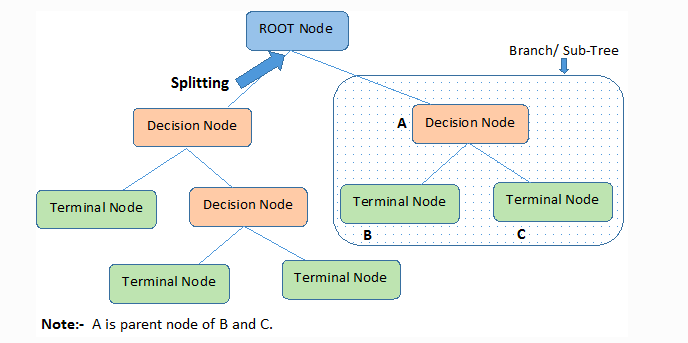
Decision trees use multiple algorithms to decide to split a node into two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that the purity of the node increases with respect to the target variable. The decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.

On the downside, decision trees are prone to overfitting. They can easily become over-complex which prevents them from generalizing well to the structure in the dataset. In that case, the model is likely to end up overfitting which is a serious issue in machine learning. To overcome this decision tree hyperparameters could be tuned. For a description of some parameters, refer to this
<a href="https://towardsdatascience.com/hyperparameters-of-decision-trees-explained-with-visualizations-1a6ef2f67edf" target="_BLANK">link</a>

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

dtModel = dt.fit(training) #WRITE CODE : Use the fit method to train the model with the training data you created in Step 4

In [33]:
dtPredictions = dtModel.transform(testing)#WRITE CODE to get predictions from the test data
#WRITE CODE to Display the predictions
dtPredictions.select('prediction','features','label').show()


+----------+--------------------+-----+
|prediction|            features|label|
+----------+--------------------+-----+
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       0.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       1.0|(30,[3,12,13,16,1...|  1.0|
|       1.0|(30,[1,11,15,16,1...|  1.0|
|       1.0|(30,[1,12,13,16,1...|  0.0|
|       1.0|(30,[9,12,14,16,1...|  1.0|
|       1.0|(30,[4,12,13,16,1...|  0.0|
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       0.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
+----------+--------------------+-----+
only showing top 20 rows



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    You can see that DecisionTree has a parameter called <code>maxDepth</code>. Discuss the significance of this parameter.
</div>

### Random Forest <a class="anchor" name="rf"></a>

In [45]:
# WRITE CODE: Implement Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
#WRITE CODE : Create a Random Forest Classiication model and train it
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3, numTrees=2)
rfModel = rf.fit(training)

In [46]:
#WRITE CODE : get the predictions for the test data
rfPredictions = rfModel.transform(testing)#WRITE CODE to get predictions from the test data
#WRITE CODE to Display the predictions
rfPredictions.select('prediction','features','label').show()

+----------+--------------------+-----+
|prediction|            features|label|
+----------+--------------------+-----+
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       0.0|(30,[7,12,15,16,1...|  1.0|
|       0.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       0.0|(30,[7,12,16,17,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       0.0|(30,[3,12,13,16,1...|  1.0|
|       1.0|(30,[1,11,15,16,1...|  1.0|
|       1.0|(30,[1,12,13,16,1...|  0.0|
|       0.0|(30,[9,12,14,16,1...|  1.0|
|       1.0|(30,[4,12,13,16,1...|  0.0|
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       0.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       0.0|(30,[7,12,13,16,1...|  1.0|
+----------+--------------------+-----+
only showing top 20 rows



### Logistic Regression <a class="anchor" name="lr"></a>
*Logistic Regression* is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. To represent binary/categorical outcome, we use dummy variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

In [59]:
# TODO: Implement Logistic Regression Classifier
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.001)
#WRITE CODE Create an initial model using the train set.
lrModel = lr.fit(training)

In [64]:
#WRITE CODE: Write the Predictions for test data and display the predictions
lrPredictions = lrModel.transform(testing)
lrPredictions.select('prediction','features','label').show()

+----------+--------------------+-----+
|prediction|            features|label|
+----------+--------------------+-----+
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       0.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,16,17,1...|  1.0|
|       1.0|(30,[3,12,13,16,1...|  1.0|
|       0.0|(30,[1,11,15,16,1...|  1.0|
|       1.0|(30,[1,12,13,16,1...|  0.0|
|       1.0|(30,[9,12,14,16,1...|  1.0|
|       1.0|(30,[4,12,13,16,1...|  0.0|
|       1.0|(30,[7,12,15,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
|       1.0|(30,[7,12,13,16,1...|  1.0|
+----------+--------------------+-----+
only showing top 20 rows



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    Discuss various parameters used in <code>Logistic Regression</code>.
</div>

## Model Evaluation <a class="anchor" name="model-evaluation"></a>
<hr />
Our goal is not just to build a model, it is about selecting a model which gives high accuracy on our sample data. There are different kinds of evaluation metrics, the choice of these depend on the type and implementation plan. More details on evaluation metrics for classification in Spark can be found <a href="https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html" target="_BLANK">here</a>.
We are going to cover the following evaluation in this session:

<ul>
    <li>
        Confusion Matrix
        <ul>
            <li>Accuracy</li>
            <li>Precision</li>
            <li>Recall</li>
            <li>F1-Score</li>
        </ul>
    </li>
    <li>AUC-ROC</li>        
    </ul>

#### Accuracy
<span style="color:red;font-weight:bold">Accuracy is useful when the target class is well balanced but is not a good choice with unbalanced classes.</span> For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.

#### Confusion Matrix <a class="anchor" name="confusion-matrix"></a>

Confusion Matrix is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values as shown in the picture below where T/F refers to true and positive respectively, and P/N to positive and negative respectively.
<div>
    <div style="float:left;width:50%">
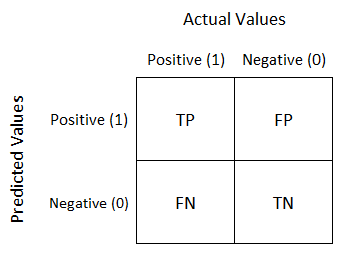
    </div>
    <div style="float:right;width:50%;padding-top:50px">
    <img src="https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png">
    </div>
    <div style="clear:both"></div>
    </div>

From the confusion matrix, we can obtain the following indicators.

- **Recall:** Out of all the positive classes, how much we predicted correctly. It should be high as possible.
- **Precision:** Out of all the positive classes we have predicted correctly, how many are actually positive.
- **Accuracy:** Out of all the classes, how much we predicted correctly. It should be high as possible.
- **F1-Score : Combining Precision and Accuracy:** It is the weighted average of Precision and Recall. It takes both <strong>False Positives</strong> and <strong>False Negative </strong> into account.

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong>
    Calculate the remaining <strong>False Negative and False Positive</strong> for <code>Decision Tree</code> based on the example below. Then Compute the other metrics, i.e. <strong>Accuracy</strong>, <strong>Precision</strong>, <strong>Recall</strong> and <strong>F1-Score</strong> for the DT Model.    
    
<strong style="color:orange">NOTE:</strong>In our case we are using Yes=1 and No=0. Remember that 1 doesn't mean positive always, it will depend on how the Target variable is encoded as well.
</div>


In [61]:
# Calculate the elements of the confusion matrix
TN = dtPredictions.filter('prediction = 0 AND label = 0').count()
TP = dtPredictions.filter('prediction = 1 AND label = 1').count()
FN = dtPredictions.filter('prediction = 0 AND label = 1').count()#WRITE CODE to find the False Negative
FP = dtPredictions.filter('prediction = 1 AND label = 0').count()#WRITE CODE to find the False Positive

# show confusion matrix
dtPredictions.groupBy('label', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (TP+TN)/(TP+TN+FN+FP)#WRITE CODE : formula to find accuracy
precision = (TP)/(TP+FP)#WRITE CODE : formula to find precision
recall = (TP)/(TP+FN)#WRITE CODE : formula to find recall
f1 = (2)/((1/recall)+(1/precision))#WRITE CODE : formula to find F1-score

#WRITE CODE : Display the various metrics calculated above
print(f"Accuracy:{accuracy}")
print(f"Precision:{precision}")
print(f"Recall:{recall}")
print(f"F1:{f1}")

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1888|
|  0.0|       1.0|  858|
|  1.0|       0.0|  207|
|  0.0|       0.0| 1469|
+-----+----------+-----+

Accuracy:0.7591587516960652
Precision:0.6875455207574654
Recall:0.9011933174224344
F1:0.7800041313778145


<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong>
    Create a function <code>compute_metrics()</code> which takes <strong>predictions</strong> as input parameter and computes all these metrics. Use the function to compute the 4 metrics for all 3 Classification Algorithms.
</div>


In [62]:
def compute_metrics(predictions):
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()#WRITE CODE to find the False Negative
    FP = predictions.filter('prediction = 1 AND label = 0').count()#WRITE CODE to find the False Positive

    # show confusion matrix
    predictions.groupBy('label', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TP+TN)/(TP+TN+FN+FP)#WRITE CODE : formula to find accuracy
    precision = (TP)/(TP+FP)#WRITE CODE : formula to find precision
    recall = (TP)/(TP+FN)#WRITE CODE : formula to find recall
    f1 = (2)/((1/recall)+(1/precision))#WRITE CODE : formula to find F1-score
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")

    #WRITE CODE: to calculate accuracy,precision,recall and f1 based on above example
    return accuracy,precision,recall,f1    

In [65]:
print("Random Forest")
compute_metrics(rfPredictions)
print("Logistic Regression")
compute_metrics(lrPredictions)
#WRITE CODE : Print the accuracy,precision,recall and f1 scores for each Classification algorithm, using the function created

Random Forest
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1487|
|  0.0|       1.0|  417|
|  1.0|       0.0|  608|
|  0.0|       0.0| 1910|
+-----+----------+-----+

Accuracy:0.7682044323835369
Precision:0.7809873949579832
Recall:0.7097852028639619
F1:0.74368592148037
Logistic Regression
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1606|
|  0.0|       1.0|  341|
|  1.0|       0.0|  489|
|  0.0|       0.0| 1986|
+-----+----------+-----+

Accuracy:0.8123021257349615
Precision:0.8248587570621468
Recall:0.7665871121718377
F1:0.7946561108362198


(0.8123021257349615,
 0.8248587570621468,
 0.7665871121718377,
 0.7946561108362198)

<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong>
  Present the accuracies, precision and recall of the different classification algorithms in a bar chart using <code>matplotlib</code>.  You can use the function given here:
    <pre>
    import matplotlib.pyplot as plt
    %matplotlib inline
    def plot_metrics(x,y):
        plt.style.use('ggplot')   
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, y, color='blue')
        plt.xlabel("Classification Algorithms")
        plt.ylabel("AUC")
        plt.title("Accuracy of ML Classification Algorithms")
        plt.xticks(x_pos, x)
        plt.show()
    </pre>
What do you observe about the differences in the accuracy/precision/recall/f1-scores for these different classification algorithms? How do you decide the most suitable metric? Discuss this with your tutor.   
</div>


In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


lr_acc,lr_pr,lr_rec,lr_f1=compute_metrics(lrPredictions)
dt_acc,dt_pr,dt_rec,dt_f1=compute_metrics(dtPredictions)
rf_acc,rf_pr,rf_rec,rf_f1=compute_metrics(rfPredictions)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1606|
|  0.0|       1.0|  341|
|  1.0|       0.0|  489|
|  0.0|       0.0| 1986|
+-----+----------+-----+

Accuracy:0.8123021257349615
Precision:0.8248587570621468
Recall:0.7665871121718377
F1:0.7946561108362198
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1888|
|  0.0|       1.0|  858|
|  1.0|       0.0|  207|
|  0.0|       0.0| 1469|
+-----+----------+-----+

Accuracy:0.7591587516960652
Precision:0.6875455207574654
Recall:0.9011933174224344
F1:0.7800041313778145
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1487|
|  0.0|       1.0|  417|
|  1.0|       0.0|  608|
|  0.0|       0.0| 1910|
+-----+----------+-----+

Accuracy:0.7682044323835369
Precision:0.7809873949579832
Recall:0.7097852028639619
F1:0.74368592148037


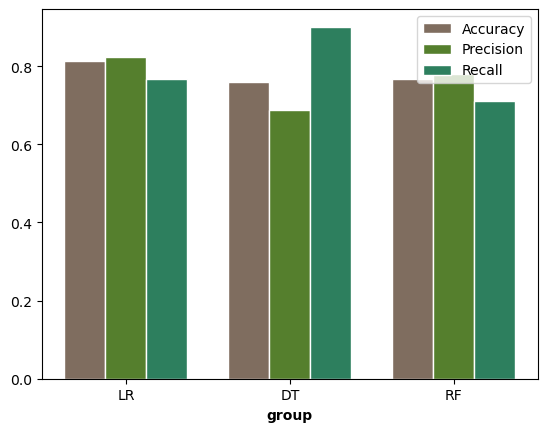

In [67]:
y_acc=[lr_acc,dt_acc,rf_acc]
y_pr=[lr_pr,dt_pr,rf_pr]
y_rec=[lr_rec,dt_rec,rf_rec]

# set width of bar
barWidth = 0.25
    
# Set position of bar on X axis
r1 = np.arange(len(y_acc))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, y_acc, color='#7f6d5f', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, y_pr, color='#557f2d', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, y_rec, color='#2d7f5e', width=barWidth, edgecolor='white', label='Recall')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(y_acc))], ['LR', 'DT', 'RF'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metrics(x,y):
    plt.style.use('ggplot')   
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, y, color='blue')
    plt.xlabel("Classification Algorithms")
    plt.ylabel("AUC")
    plt.title("Accuracy of ML Classification Algorithms")
    plt.xticks(x_pos, x)
    plt.show()
    


#### Area Under the Curve (AUC-ROC) <a class="anchor" name="roc"></a>
When we need to check or visualize the performance of the multi - class classification problem, we use AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance.

<br/><br/>

<div style="width:40%;float:left;text-align:left;">
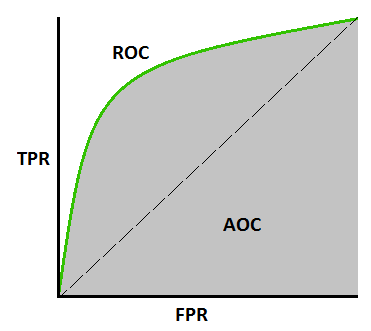
    </div><div style="width:60%;float:right;text-align:justify">
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.
    
In the example below, we are using Spark's <code>BinaryClassificationEvaluator</code> to compute the AUC-ROC curve.
   </div>
   <div style="clear:both"></div> 

##### Binary Classification Metrics <a class="anchor" name="bce"></a> 
Now let's evaluate the model using BinaryClassificationMetrics class in Spark ML. BinaryClassificationMetrics by default uses areaUnderROC as the performance metric.
<a href="https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification" target='_BLANK'>Read More</a>

<a class="anchor" id="lab-task-5"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">5. Lab Task: </strong>
    Compute the <code>Area Under ROC</code> for the two other Algorithms based on the example below.
</div>


In [68]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_dt = evaluator.evaluate(dtPredictions)
print(auc_dt)
print(evaluator.getMetricName())

0.7963253823282357
areaUnderROC


In [69]:
#WRITE CODE : area under curve for Random Forest
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_dt = evaluator.evaluate(rfPredictions)
print(auc_dt)
print(evaluator.getMetricName())

0.8149713901250548
areaUnderROC


In [70]:
#WRITE CODE : area under curve for Logistic Regression

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_dt = evaluator.evaluate(lrPredictions)
print(auc_dt)
print(evaluator.getMetricName())

0.8894739865006932
areaUnderROC


### Visualizing AUC-ROC <a class="anchor" name="roc-viz"></a> 
We can easily visualize the ROC curve for <strong>Logistic Regression</strong> using the <code>BinaryClassificationEvaluator</code>. The example below shows how to plot it using matplotlib.


Area Under ROC: 0.8894739865006932


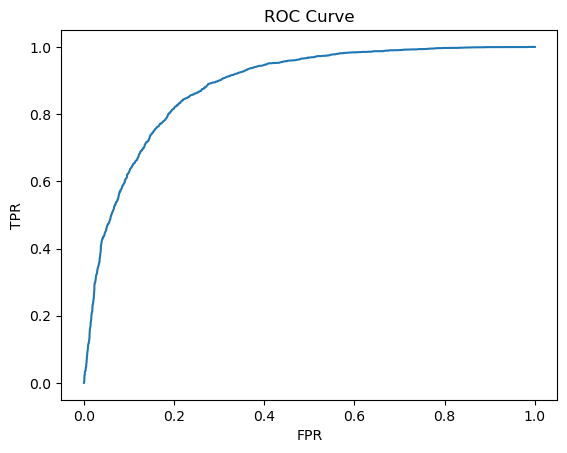

In [71]:
import matplotlib.pyplot as plt

print("Area Under ROC: " + str(evaluator.evaluate(lrPredictions, {evaluator.metricName: "areaUnderROC"})))

# Plot ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

<div style="background:rgba(164,0,255,0.2);padding:10px;border-radius:4px">
However, for other algorithms, we need to calculate it manually. The ROC Curve is simply a line plot of <code>FPR</code> and <code>TPR</code> across all thresholds (i.e. 0-1). We can calculate <code>TPR</code> and <code>FPR</code> from the confusion matrix. However, by default, a threshold value of 0.5 is used while computing the confusion matrix. So we need a way to compute the confusion matrix for different thresholds.</div>

##### Getting the thresholds
We can simply use numpy <code>linspace</code> to get a list of thresholds.

In [72]:
import numpy as np
print(np.linspace(0, 1, 100))

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

If we look at the <code>probability</code> column of the predictions, we will see it is an <code>Array</code> with two probability values, the first one for negative class and the second one for positive class. Now we can consider the <strong>probability for positive class</strong> to decide which value is <strong>positive</strong> and which value is <strong>negative</strong>

For example, if our threshold is 0.7, we can say <strong>if the positive probability is greater than 0.7, it is a positive prediction else it is a negative prediction</strong>. 

Here is an example for the Decision Tree Predictions.

In [73]:
#User Defined Function to split the probabilities into two columns
import pyspark.sql.functions as F
import pyspark.sql.types as T
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

In [74]:
#Splitting the probability to 2 parts using the UDF
df = dtPredictions.withColumn('probability', to_array('probability'))

In [75]:
#A new df which contains the probabilites in separate columns
prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'label')

Now, we have extracted the probabilities for positive and negative class. Now we need to create our own <code>prediction</code> column based on a threshold we are provided.

In [76]:
#Here based on the threshold, the prediction column is computed
threshold=0.7
prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))

DataFrame[negative_prob: float, positive_prob: float, label: double, prediction: int]

Now we can create the confusion metrics based on the new predicted class. Let's create a function to do that. The function returns the TN,TP,FN and FP values.

CHALLENGE TASK: the following confusion_matrix function is slow, why is it so slow? Can you refactor it?

Possible solution - use groupby('prediction', 'label').count() to calculate the counts instead of doing it four times

In [77]:
def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    return TP,TN,FP,FN

In [78]:
#TESTING 
#for threshold 0.7, lets calculate the TN,TP,FN,FP from confusion matrix
threshold=0.7
test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
tp,tn,fp,fn = confusion_matrix(prob_df)  
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
print('TPR:',tpr,'FPR:',fpr)

TPR: 0.9011933174224344 FPR: 0.3687150837988827


<a class="anchor" id="challenge-task"></a>
<div style="background:rgba(164,0,255,0.2);padding:10px;border-radius:4px"><strong style="color:purple">CHALLENGE TASK: </strong>
    Based on all the above information, create a function, which loops through all the thresholds and computes the <code>TPR</code> and <code>TFR</code> for each threshold. Store all the <code>TPR</code> and <code>TFR</code> values in separate arrays and later visualize the <strong>ROC Curve</strong> for <strong>Decision Tree</strong> and <strong>Random Forest</strong>.
</div>


In [ ]:
#WRITE CODE 

### Congratulations on finishing this activity. See you next week.

## References

1. https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html
2. https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html